In [1]:
import pandas as pd
import numpy as np

import altair as alt

import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as grid_finder
import mpl_toolkits.axisartist.floating_axes as floating_axes

%matplotlib inline

In [2]:
# From this link: https://github.com/mabelcalim/Taylor_diagram

def Taylor_diag(series, names):
    """
        Taylor Diagram : obs is reference data sample
        in a full diagram (0 --> npi)
        --------------------------------------------------------------------------
        Input: series     - dict with all time series (lists) to analyze  
               series[0]  - is the observation, the reference by default.
    """
    corr, std = {}, {}
    for i in series.keys():
        corr[i] = np.ma.corrcoef(series[0], series[i])[1, 0]
        std[i] = np.ma.std(series[i]) / np.ma.std(series[0])
       
    reference_value = 1  # ma.std(series[0])
    #print corr
    
    rlocs = np.concatenate((np.arange(0, -10, -0.25), [-0.95,-0.99],
                            np.arange(0,10,0.25), [0.95,0.99]))
    str_rlocs = np.concatenate((np.arange(0,10,0.25), [0.95,0.99],
                                np.arange(0,10,0.25), [0.95,0.99]))
    tlocs = np.arccos(rlocs)        # Conversion to polar angles
    grid_locator_1 = grid_finder.FixedLocator(tlocs)    # Positions
    tick_formatter_1 = grid_finder.DictFormatter(
        dict(zip(tlocs, map(str, rlocs))))

    str_locs2 = np.arange(-10, 11, 0.5)
    tlocs2 =  np.arange(-10, 11, 0.5)      
       
    grid_locator_2 = grid_finder.FixedLocator(tlocs2)  # ALEKS: THIS IS NOT USED ANYWHERE, CHECK
    tick_formatter_2 = grid_finder.DictFormatter(
        dict(zip(tlocs2, map(str, str_locs2))))
    
    base_transform = PolarAxes.PolarTransform()
    
    smin = 0
    smax = 2.5

    grid_helper = floating_axes.GridHelperCurveLinear(
        base_transform,
        extremes=(0, np.pi, smin, smax),  # 1st quadrant
        grid_locator1=grid_locator_1,
        #grid_locator2=grid_locator_2,
        tick_formatter1=tick_formatter_1,
        tick_formatter2=tick_formatter_2)
    
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)

    fig.add_subplot(ax)
    ax.axis["top"].set_axis_direction("bottom") 
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation Coefficient")

    ax.axis["left"].set_axis_direction("bottom") 
    ax.axis["left"].label.set_text("Standard Deviation")

    ax.axis["right"].set_axis_direction("top") 
    ax.axis["right"].toggle(ticklabels=True, label=True)
    ax.axis["right"].set_visible(True)
    ax.axis["right"].major_ticklabels.set_axis_direction("bottom")
    #ax.axis["right"].label.set_text("Standard Deviation")
    
    ax.axis["bottom"].set_visible(False) 
    ax.grid(True)
    ax = ax.get_aux_axes(base_transform)

    t = np.linspace(0, np.pi)
    r = np.zeros_like(t) + reference_value
    ax.plot(t, r, 'k--', label='_')

    rs, ts = np.meshgrid(np.linspace(smin, smax), np.linspace(0, np.pi))

    rms = np.sqrt(reference_value**2 + rs**2 - 2*reference_value*rs*np.cos(ts))
    CS =ax.contour(ts, rs, rms, cmap=plt.matplotlib.cm.bone)
    plt.clabel(CS, inline=1, fontsize=10)
    
    ax.plot(np.arccos(0.9999), reference_value, 'k', marker='*', ls='', ms=10)
    aux = range(1, len(corr))
    #del aux[reference_value]

    colors = plt.matplotlib.cm.jet(np.linspace(0, 1, len(corr)))
    
    for i in aux:
        ax.plot(np.arccos(corr[i]), std[i], c=colors[i], alpha=0.7, ms=15,
                marker='o', label=" %s" % names[i])
        ax.text(np.arccos(corr[i]), std[i], "%s" % i, fontsize=12)
    plt.legend(bbox_to_anchor=(1.5, 1), prop=dict(size='large'), loc='best')
    plt.plot()  # ALEKS: Changed from savefig("example.png", dpi=300)
    return


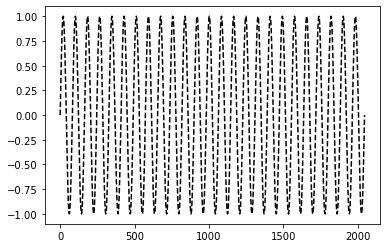

In [3]:
z = np.linspace(0,2048,2048)
x = np.sin(50*np.pi*z)
y = np.cos(50*np.pi*z)
x2 = 2*np.sin(50*np.pi*z)

plt.plot(x, 'k--')

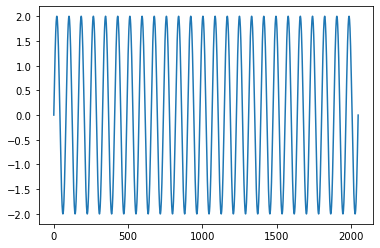

In [4]:
plt.plot(x2)

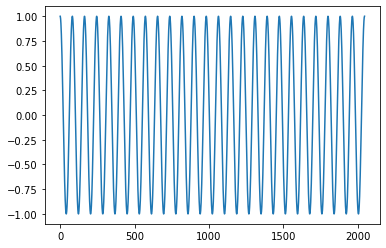

In [5]:
plt.plot(y)

In [6]:


series ={}
series[0] = x  # the first term will be always the reference_valueerence signal 
series[1]= x2
series[2]= y



/tmp/ipykernel_35006/58375158.py:23: RuntimeWarning: invalid value encountered in arccos
  tlocs = np.arccos(rlocs)        # Conversion to polar angles


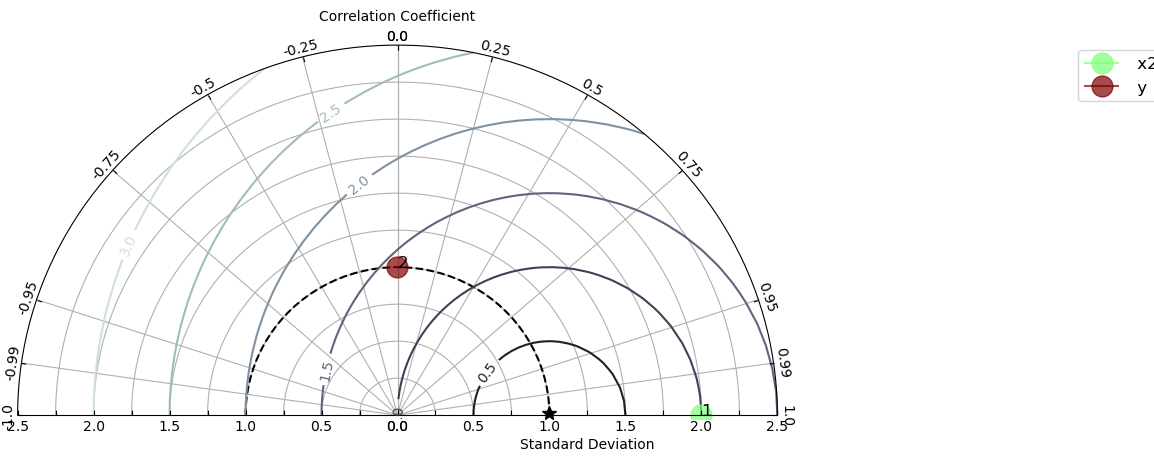

In [7]:
Taylor_diag(series,['x','x2','y'])

In [8]:
source = pd.DataFrame({"values": [12, 23, 47, 6, 52, 19]})

base = alt.Chart(source).encode(
    theta=alt.Theta("values:Q", stack=True),
    radius=alt.Radius("values", scale=alt.Scale(type="sqrt", zero=True, rangeMin=20)),
    color="values:N",
)

c1 = base.mark_arc(innerRadius=20, stroke="#fff")

c2 = base.mark_text(radiusOffset=10).encode(text="values:Q")

c1 + c2

alt.LayerChart(...)

In [47]:
df_new = pd.DataFrame(dict(
    {
        'theta_deg': range(10, 190, 10),
        'theta_2_deg': range(0, 180, 10),
        #'r': range(0, 180, 10),
    }))

df_new['theta_rad'] = np.pi * (df_new['theta_deg']/180)
df_new['theta_2_rad'] = np.pi * (df_new['theta_2_deg']/180)
df_new['theta_labels'] = [str(i) for i in df_new['theta_deg']]

df_new

,theta_deg,theta_2_deg,theta_rad,theta_2_rad,theta_labels
0,10,0,0.174533,0.000000,10
1,20,10,0.349066,0.174533,20
2,30,20,0.523599,0.349066,30
3,40,30,0.698132,0.523599,40
4,50,40,0.872665,0.698132,50
5,60,50,1.047198,0.872665,60
6,70,60,1.221730,1.047198,70
7,80,70,1.396263,1.221730,80
8,90,80,1.570796,1.396263,90
9,100,90,1.745329,1.570796,100


In [50]:
float_start_circle = -np.pi*0.5
float_end_circle = np.pi*0.5

chart_base = alt.Chart(df_new).encode(
    theta=alt.Theta('theta_rad:Q', scale=alt.Scale(type='linear', rangeMax=float_end_circle, rangeMin=float_start_circle)),
    theta2=alt.Theta2('theta_2_rad:Q')
)

chart_circle = chart_base.mark_arc(color='white', opacity=0.8, stroke='black', strokeWidth=0.2, outerRadius=500)
chart_text = chart_base.mark_text(radius=520, size=10).encode(text='theta_labels:N')


chart_result = alt.layer(chart_circle, chart_text)
chart_result

alt.LayerChart(...)

In [11]:
# From this link: https://colab.research.google.com/drive/19WJ8L2NlWA7xrDhieHE1Zvi90hyZAjcR?usp=sharing#scrollTo=f4ufHavradwW

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

In [12]:
class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.5 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')
        
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        
        # Useless
        ax.axis['bottom'].set_visible(False)
        
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=8, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, r, l, fname):
    fig=plt.figure()
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='Observed')
    plt.clabel(dia.add_contours(colors='0.5'), inline=1, fontsize=10)
    cs = plt.matplotlib.cm.Set1(np.linspace(0, 1, len(l)))
    srlc = zip(s, r, l, cs)
    
    for i in srlc:
        dia.add_sample(i[0], i[1], label=i[2], c=i[3], marker='s', markersize=12)
    
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7, 0.7])
    plt.title('Taylor diagram')
    plt.plot()
    #plt.savefig(fname, dpi=300, bbox_inches='tight')
    #plt.clf()
    #plt.close(fig)

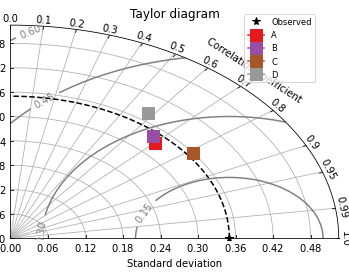

In [13]:
# Standard deviation of observed data
obsSTD = 0.35

# Standard deviation of each predicted data
s = [0.33, 0.34, 0.36, 0.38]

# The correlation coefficient of each predicted data
r = [0.70, 0.67, 0.81, 0.58]

# Labels of each predicted data
l = ['A', 'B', 'C', 'D']

# Output file name
fname = 'TaylorDiagram.jpg'

# Note:s, r, and l has the same length

srl(obsSTD, s, r, l, fname)


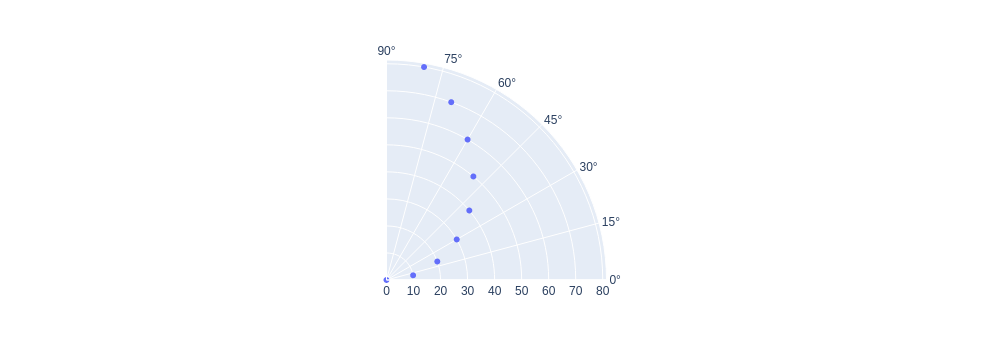

In [149]:
import os
import plotly
import plotly.express as px
import numpy as np
import pandas as pd

fig = px.scatter_polar(r=range(0,90,10), theta=range(0,90,10),
                       range_theta=[0,90], start_angle=0, direction="counterclockwise")
fig.show()


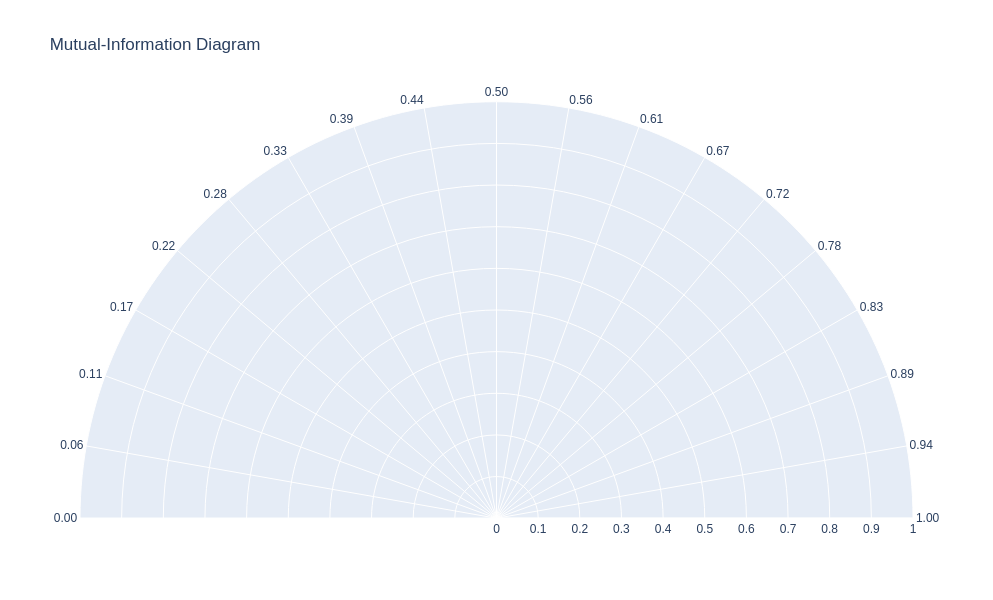

In [147]:
# range_r is adaptable to the data (entropy between models)

chart_base = px.scatter_polar(
    range_r=[0, 1],
    title='Mutual-Information Diagram',
    
)

list_angular_ticks = [i for i in range(-360, -170, 10)]
list_angular_labels = ["{:.2f}".format(i)
                       for i in np.linspace(0, 1, len(list_angular_ticks))]

chart_base.update_layout(
    polar = dict(
        sector = [0, 180],
        angularaxis = dict(
            thetaunit = "degrees",
            #dtick = 45,
            rotation=180,
            direction = "clockwise",
            tickmode="array",
            tickvals=list_angular_ticks,
            ticktext=list_angular_labels
            )
    ),
    height=600
)

chart_base.show()

In [ ]:
path_root_data = os.path.join('..', 'Data')
path_anscombes_quartet = os.path.join(path_root_data, 'Anscombes_Quartet.csv')

df_anscombes_quartet = pd.read_csv(path_anscombes_quartet)
df_anscombes_quartet